In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing the libraries

In [ ]:
import pandas as pd
import time
import datetime
!pip install praw
import praw
import praw.exceptions
import numpy as np
from scipy.sparse import csr_matrix
import nltk
import matplotlib.pyplot as plt
import datetime
from datetime import date
import time
import pickle
import scipy
import scipy.sparse as sps
!pip install louvain
import louvain
import igraph as ig

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 15.0 MB/s eta 0:00:00


<ipython-input-2-48d300182c17>:18: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import louvain


Implementing Reddit API

In [ ]:
# Create a Reddit instance using the praw package.
reddit = praw.Reddit(
    client_id='CWJjVr1bEeH44Y5n86HcnA',
    client_secret='eT7xoyngTgl-9AlqoQO56nSakFuEig',
    user_agent='barbie_project',
    check_for_async=False
)

Data Extraction

In [ ]:
keyword = ['WhitePeopleTwitter', "movies" , "AskMen" , "Cinema", "BarbieTheMovie"]

# Search for subreddits related to the keyword
subreddits = reddit.subreddits.search(keyword, limit=100)
DF = pd.DataFrame(vars(subreddit) for subreddit in subreddits)
DF = DF[['display_name','subscribers']].sort_values(by='subscribers',ascending = False)

# show result
DF.dropna(inplace=True)
display(DF)
subreddits_name_list = list(DF['display_name'])


,display_name,subscribers
31,AskReddit,44976084
19,movies,32270397
48,AmItheAsshole,14026588
9,TwoXChromosomes,13661908
35,facepalm,7980381
21,entertainment,4572335
23,NoStupidQuestions,4333968
27,unpopularopinion,4147928
22,teenagers,3005998
13,popculturechat,2372788


In [ ]:
# Define a function to read posts from a specified subreddit.
def read_reddit(subreddit_name, total_posts_to_retrieve,
                time_filter, sort_mode, keywords, batch_size = 250):

    subreddit = reddit.subreddit(subreddit_name)
    all_posts = []
    retrieved_posts = 0
    current_batch = 0
    after_param = ''

    # Loop to read reddit posts in batches until the desired number of posts is retrieved.
    while retrieved_posts < total_posts_to_retrieve:
        remaining_posts = total_posts_to_retrieve - retrieved_posts
        posts_to_retrieve = min(remaining_posts, batch_size)
        collected_posts = list(subreddit.search(keywords,
                                                limit=posts_to_retrieve,
                                                time_filter=time_filter,
                                                sort=sort_mode,
                                                params={'after': after_param}))
        if not collected_posts: break
        all_posts.extend(collected_posts)
        retrieved_posts += len(collected_posts)
        current_batch += 1
        after_param = 't3_' + all_posts[-1].id

    df = pd.DataFrame(vars(post) for post in all_posts) # turn into dataframe
    print('a total of ' + str(len(df)) + ' posts have been collected out of '
                        + str(total_posts_to_retrieve))
    return df

In [ ]:
# Set search criteria for the Reddit API
total_posts_to_retrieve = 1000
time_filter = 'year' # "all", "day", "hour", "month", "week", or "year"
sort_mode = 'top' # "relevance", "hot", "top", "new", or "comments"
keywords = 'barbie'

dfs = []
# Iterate over each subreddit in the list
for subreddit_name in subreddits_name_list :
    print(subreddit_name)
    df = read_reddit(subreddit_name, total_posts_to_retrieve, time_filter,
                 sort_mode, keywords, batch_size=100)
    dfs.append(df)


# Merge all the collected dataframes into a single dataframe
final_df = pd.concat(dfs, ignore_index=True)

# Select specific columns of interest from the merged dataframe
final_df = final_df[['id','created','subreddit','title','selftext','author',
         'author_fullname','upvote_ratio','ups','num_comments']]

# Convert timestamp to a readable date format
final_df["created"] = [datetime.date.fromtimestamp(i) for i in final_df["created"]]

# Save the final dataframe to a CSV file
final_df.to_csv('drive/MyDrive/NetworkScience_Project/Reddit/barbie_reddit.csv', index=True)

# Display the final dataframe
display(final_df)

AskReddit
a total of 217 posts have been collected out of 1000
movies
a total of 242 posts have been collected out of 1000
AmItheAsshole
a total of 150 posts have been collected out of 1000
TwoXChromosomes
a total of 133 posts have been collected out of 1000
facepalm
a total of 52 posts have been collected out of 1000
entertainment
a total of 172 posts have been collected out of 1000
NoStupidQuestions
a total of 189 posts have been collected out of 1000
unpopularopinion
a total of 22 posts have been collected out of 1000
teenagers
a total of 213 posts have been collected out of 1000
popculturechat
a total of 242 posts have been collected out of 1000
Nails
a total of 241 posts have been collected out of 1000
Fauxmoi
a total of 181 posts have been collected out of 1000
childfree
a total of 31 posts have been collected out of 1000
OUTFITS
a total of 157 posts have been collected out of 1000
cosplay
a total of 52 posts have been collected out of 1000
boxoffice
a total of 241 posts have bee

,id,created,subreddit,title,selftext,author,author_fullname,upvote_ratio,ups,num_comments
0,18wdasp,2024-01-02,AskReddit,What other actress aside from Margot Robbie wo...,,Draclin,t2_5r5b86iu,0.87,1129,608
1,15670w1,2023-07-22,AskReddit,"If not for Margot Robbie, who would you cast a...",,TheTurtleFranklin,t2_1ncpxjx1,0.78,12,79
2,15nwtix,2023-08-11,AskReddit,What job should Barbie have next?,,SeraphOfFire,t2_3o1y3k14,0.68,13,104
3,155ishb,2023-07-21,AskReddit,"So, redditors who have watched either, how goo...",,Adsilom,t2_30xx1jeb,0.79,8,29
4,1561xmr,2023-07-21,AskReddit,If Barbie and Oppenheimer being released on th...,,EssexGuyUpNorth,t2_mgmhawtb,0.81,10,5
...,...,...,...,...,...,...,...,...,...,...
6275,14iruy4,2023-06-25,Barbie2023,Barbie Movie 2023 reaction👗#barbiemovie #barbi...,Check out my YouTube channel and subscribe 💃\n...,Okra_Dismal,t2_dkbjsst6,0.66,1,2
6276,154fv4t,2023-07-20,Barbie2023,"Reacting to the New ""Barbie Movie | Main Trail...",,SedateTheApe,t2_j77qmsj0,1.00,1,0
6277,154v23g,2023-07-20,Barbie2023,Barbie Movie Review!!,,Aryan_p12,t2_93jtxy7,1.00,1,0
6278,15lfn62,2023-08-08,Barbie2023,Cartoon Barbie (2023) in different styles,,Poonker,t2_brnwe,0.67,1,0


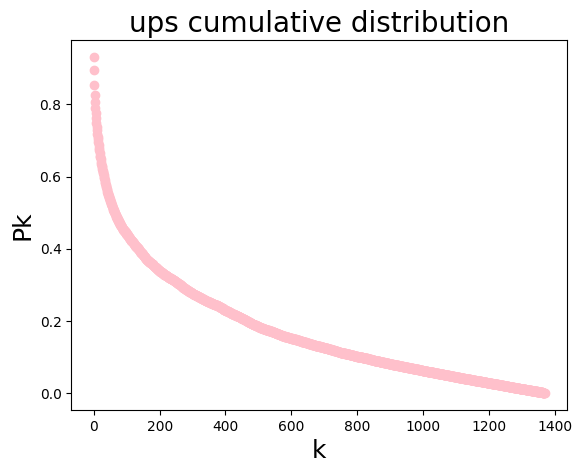

In [ ]:
# Plot ups distribution
import numpy as np
ups = np.squeeze(np.array(final_df["ups"]+1))
k = np.unique(ups)
pk = np.histogram(ups,k)[0]
pk = pk/pk.sum()
Pk = 1-np.cumsum(pk)
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(Pk,'o', color='pink')
plt.title("ups cumulative distribution", size=20)
plt.xlabel("k", size=18)
plt.ylabel("Pk", size=18)
plt.show()

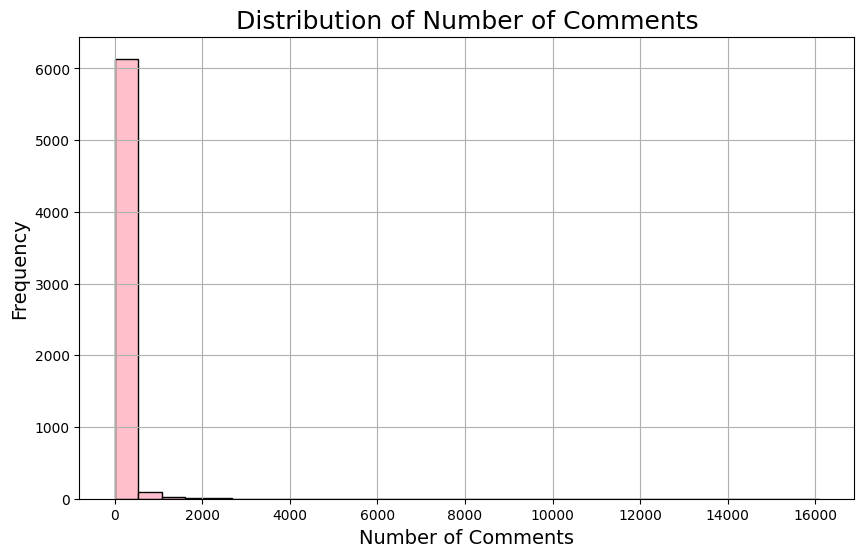

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(final_df["num_comments"], bins=30, color='pink', edgecolor='black')
plt.title("Distribution of Number of Comments", size=18)
plt.xlabel("Number of Comments", size=14)
plt.ylabel("Frequency", size=14)
plt.grid(True)
plt.show()


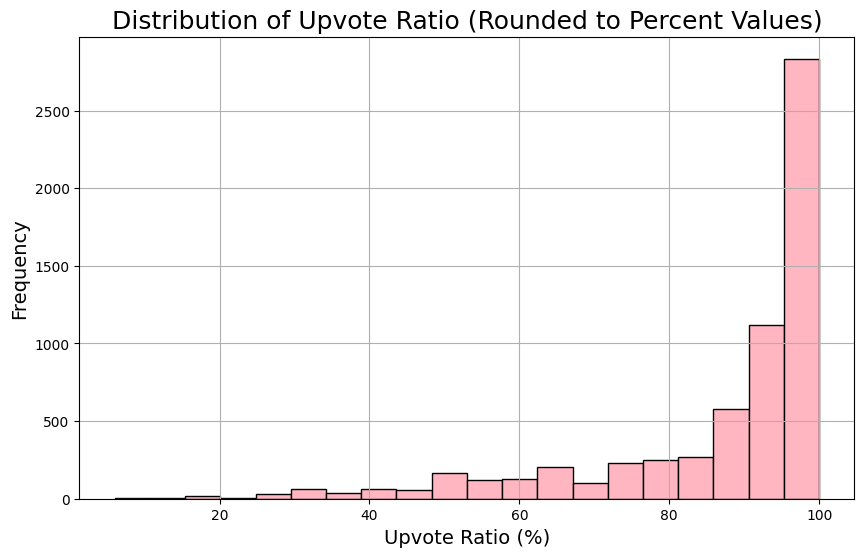

In [ ]:
# Rounding upvote ratio to percent values
final_df["upvote_ratio_percent"] = (final_df["upvote_ratio"] * 100).round()

# Plotting the distribution of the rounded upvote ratio
plt.figure(figsize=(10, 6))
plt.hist(final_df["upvote_ratio_percent"], bins=20, color='lightpink', edgecolor='black')
plt.title("Distribution of Upvote Ratio (Rounded to Percent Values)", size=18)
plt.xlabel("Upvote Ratio (%)", size=14)
plt.ylabel("Frequency", size=14)
plt.grid(True)
plt.show()

In [ ]:
# Filtering the dataframe, keeping the posts that have more than 200 ups
final_df_selected = final_df.copy()
final_df_selected = final_df_selected.loc[final_df_selected['ups'] >=200]
display(final_df_selected)

,id,created,subreddit,title,selftext,author,author_fullname,upvote_ratio,ups,num_comments,upvote_ratio_percent
0,18wdasp,2024-01-02,AskReddit,What other actress aside from Margot Robbie wo...,,Draclin,t2_5r5b86iu,0.87,1129,608,87.0
217,15jrcr4,2023-08-06,movies,'Barbie' Officially Passes $1 Billion Globally...,,MarvelsGrantMan136,t2_5adwlxvn,0.86,40863,3162,86.0
218,15sr5qx,2023-08-16,movies,‘Barbie’ Surpasses ‘The Dark Knight’ as Warner...,,Key_Damage_9220,t2_4nelec8j8,0.87,28741,2406,87.0
219,13rll7o,2023-05-25,movies,Barbie | Main Trailer,,ICumCoffee,t2_90uq6p5q,0.86,21634,2500,86.0
220,12bnhom,2023-04-04,movies,Barbie | Teaser Trailer 2,,DemiFiendRSA,t2_165g7s,0.86,19232,2118,86.0
...,...,...,...,...,...,...,...,...,...,...,...
5953,158csb9,2023-07-24,saltierthankrayt,TFM REALLY don't get the Barbie movie.,"Okay, been listening to some TFM reviews of th...",Serpenthrope,t2_11c8e5,0.96,235,68,96.0
5954,156bwam,2023-07-22,saltierthankrayt,She Spittin Though!,,TripleS034,t2_w57jxvbt,1.00,230,18,100.0
5955,1544xiu,2023-07-19,saltierthankrayt,It's gonna be so fun when Barbie makes like $1...,,splooge-clues,t2_85799ld6,0.98,223,87,98.0
5956,155hg5o,2023-07-21,saltierthankrayt,Salute To The Person Who Posted To The Shadive...,,TripleS034,t2_w57jxvbt,0.99,224,63,99.0


In [ ]:
# Defining a function to extract comments from a list of post IDs
def extract_comments(post_id_list):

    all_comments = []

    # Loop through each post ID in the provided list
    for i in range(len(post_id_list)):

        try:
            post_id = post_id_list[i]
            submission = reddit.submission(id=post_id)
            submission.comments.replace_more(limit=None)
            collected_comments = list(submission.comments)
            all_comments.extend(collected_comments)
            print(f"Downloaded {len(collected_comments)} comments for post number {i}, id = {post_id}")

        except Exception as error:
            print(f"Rate limit exceeded. Waiting for a moment. Error: {error}")
            time.sleep(7)
            continue

    # Convert the list of comments into a DataFrame
    df = pd.DataFrame(vars(post) for post in all_comments)
    print('a total of ' + str(len(df)) + ' comments have been retrieved')
    return df

In [12]:
# Extract comments from the selected posts
comments_df = extract_comments(list(final_df_selected['id']))

# Filter the DataFrame to keep only the columns that are useful
comments_df = comments_df[['id','parent_id','created','subreddit','body',
         'author','author_fullname','ups','downs']]

# Convert timestamp to a readable format
comments_df["created"] = [datetime.date.fromtimestamp(i) for i in comments_df["created"]]

# Save the filtered and processed comments DataFrame to a CSV file
comments_df.to_csv('drive/MyDrive/NetworkScience_Project/Reddit/barbie2_reddit.csv', index=True)

# Display the processed comments DataFrame
display(comments_df)

Downloaded 278 comments for post number 0, id = 18wdasp
Downloaded 431 comments for post number 1, id = 15jrcr4
Downloaded 477 comments for post number 2, id = 15sr5qx
Downloaded 764 comments for post number 3, id = 13rll7o
Downloaded 648 comments for post number 4, id = 12bnhom
Downloaded 287 comments for post number 5, id = 14h2f2n
Downloaded 464 comments for post number 6, id = 19cro5j
Downloaded 287 comments for post number 7, id = 14p1ufy
Downloaded 219 comments for post number 8, id = 15fj46g
Rate limit exceeded. Waiting for a moment. Error: received 429 HTTP response
Downloaded 126 comments for post number 10, id = 14pd7s9
Downloaded 59 comments for post number 11, id = 18bfdu4
Downloaded 153 comments for post number 12, id = 12bivur
Rate limit exceeded. Waiting for a moment. Error: received 429 HTTP response
Downloaded 370 comments for post number 14, id = 18cxgrf
Downloaded 163 comments for post number 15, id = 15n0rtr
Downloaded 82 comments for post number 16, id = 15zkb93
Do

Downloaded 232 comments for post number 874, id = 155xtm6
Downloaded 74 comments for post number 875, id = 15bktsz
Downloaded 35 comments for post number 876, id = 16sb4qk
Downloaded 53 comments for post number 877, id = 16o2ebw
Downloaded 142 comments for post number 878, id = 18scd2a
Downloaded 76 comments for post number 879, id = 150owch
Downloaded 113 comments for post number 880, id = 166cb96
Downloaded 62 comments for post number 881, id = 15jo0p5
Downloaded 46 comments for post number 882, id = 159k4nn
Downloaded 51 comments for post number 883, id = 155ofgx
Downloaded 38 comments for post number 884, id = 14tb4cd
Downloaded 54 comments for post number 885, id = 15h1n37
Downloaded 53 comments for post number 886, id = 137eag9
Downloaded 43 comments for post number 887, id = 1919k4q
Downloaded 59 comments for post number 888, id = 156lpwa
Downloaded 48 comments for post number 889, id = 154prb0
Downloaded 21 comments for post number 890, id = 15927ok
Downloaded 21 comments for p

,id,parent_id,created,subreddit,body,author,author_fullname,ups,downs
0,kfy6vlc,t3_18wdasp,2024-01-02,AskReddit,"Miss Piggy, but every other actor plays it str...",whatsnewpussykat,t2_amzme,2178,0
1,kfxhjiz,t3_18wdasp,2024-01-02,AskReddit,Character actress Margot Martindale,daguy9,t2_iej6e,3072,0
2,kfx3uoh,t3_18wdasp,2024-01-02,AskReddit,[Jamie Pressly](https://duckduckgo.com/?q=Jami...,oh_bruddah,t2_324m9,2480,0
3,kfxxvud,t3_18wdasp,2024-01-02,AskReddit,Diana Agron!,just_justine93,t2_e2j3ec,530,0
4,kfxbhk2,t3_18wdasp,2024-01-02,AskReddit,Alyssa edwards,Parking_Web_726,t2_a5zsiifc,1340,0
...,...,...,...,...,...,...,...,...,...
126745,kjfs3pe,t3_19en8h6,2024-01-25,saltierthankrayt,I will fully acknowledge that this discourse i...,Sentric490,t2_w4g33wt,1,0
126746,kjfw7mc,t3_19en8h6,2024-01-25,saltierthankrayt,*The backlash to the backlash to the thing tha...,Skytree91,t2_635doj73,1,0
126747,kjguu91,t3_19en8h6,2024-01-25,saltierthankrayt,The only people from Barbie who should be gett...,BucktoothedAvenger,t2_t7k0kp6n,1,0
126748,kjjdcbl,t3_19en8h6,2024-01-25,saltierthankrayt,WTF did I just read?,LazilyPunctual,t2_900u3xhh,1,0


In [13]:
%run "drive/MyDrive/NetworkScience_Project/Reddit/cleaning_mod.ipynb"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=839f3ffe609bfdb34531a0a506f567d6df29c7c2b760ca54462501349f420b5a
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.6 MB/s eta 0:00:00


In [ ]:
in_dir = "drive/MyDrive/NetworkScience_Project/Reddit/"
in_file = "barbie_reddit"
df = pd.read_csv(in_dir+in_file+".csv")
df = df[["id","created","title"]] # we only keep a few meaningful entries
display(df)

In [15]:
# Perform initial cleaning on the title column to remove basic noise
df['text_sup_clean'] = df['title'].apply(superficial_cleaning)

# Perform Deep cleaning
POS_KEEP = ["ADJ","ADV","NOUN","PROPN","VERB","NUM"] # we do not include "PRON"
df['text_deep_clean'] = df['text_sup_clean'].apply(deep_cleaning)
df['text_deep_clean_pos'] = df['text_sup_clean'].apply(deep_cleaning_pos)

# Identify and extract any hashtags from the 'title' column
df['hashtags'] = df['title'].apply(get_hashtags)

# Display the result
display(df)

<ipython-input-13-6f1622b626a2>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(selftext, "html.parser")


,id,created,title,text_sup_clean,text_deep_clean,text_deep_clean_pos,hashtags
0,18wdasp,2024-01-02,What other actress aside from Margot Robbie wo...,what other actress aside from margot robbie wo...,actress aside margot robbie good pick stereoty...,"[other ADJ, actress NOUN, aside ADV, margot PR...",[]
1,15670w1,2023-07-22,"If not for Margot Robbie, who would you cast a...",if not for margot robbie who would you cast as...,margot robbie cast barbie,"[margot PROPN, robbie PROPN, cast VERB, barbie...",[]
2,15nwtix,2023-08-11,What job should Barbie have next?,what job should barbie have next,job barbie,"[job NOUN, barbie VERB, have VERB, next ADJ]",[]
3,155ishb,2023-07-21,"So, redditors who have watched either, how goo...",so redditors who have watched either how good ...,redditor watch good bad barbie oppenheimer,"[redditor NOUN, watch VERB, good ADJ, bad ADJ,...",[]
4,1561xmr,2023-07-21,If Barbie and Oppenheimer being released on th...,if barbie and oppenheimer being released on th...,barbie oppenheimer release day barbenheimer ne...,"[barbie PROPN, oppenheimer NOUN, release VERB,...",[]
...,...,...,...,...,...,...,...
6275,14iruy4,2023-06-25,Barbie Movie 2023 reaction👗#barbiemovie #barbi...,barbie movie reaction,barbie movie reaction,"[barbie PROPN, movie NOUN, reaction NOUN]","[barbiemovie, barbie2023, barbieworld]"
6276,154fv4t,2023-07-20,"Reacting to the New ""Barbie Movie | Main Trail...",reacting to the new barbie movie main trailer ...,react new barbie movie main trailer ryan gosle,"[react VERB, new ADJ, barbie NOUN, movie NOUN,...",[]
6277,154v23g,2023-07-20,Barbie Movie Review!!,barbie movie review,barbie movie review,"[barbie PROPN, movie NOUN, review NOUN]",[]
6278,15lfn62,2023-08-08,Cartoon Barbie (2023) in different styles,cartoon barbie in different styles,cartoon barbie different style,"[cartoon PROPN, barbie PROPN, different ADJ, s...",[]


In [16]:
mask = '2023-07-21'

df_after = df[df['created']>=mask]
df_after = df_after.reset_index()


In [17]:
# Save the results
out_dir = "drive/MyDrive/NetworkScience_Project/Reddit/"
out_file = "final_barbie_reddit_"

df_after.to_excel(out_dir+out_file+"after_cleaned.xlsx", index=True)

In [18]:
# Create a unique collection of words
words_after = np.unique([item for sublist in df_after['text_deep_clean_pos'] for item in sublist])
# Create a dictionary where each unique word is mapped to a unique integer.
words_dict_after = dict(zip(words_after,range(len(words_after))))
# Initialize an occurrence matrix
Mwd_after = csr_matrix((len(words_dict_after), len(df_after)), dtype = np.int8).toarray()
for i in range(len(df_after)):
  for j in df_after['text_deep_clean_pos'][i]:
    Mwd_after[words_dict_after[j],i] += 1

In [19]:
# Collect a unique set of hashtags from the 'hashtags' column
hashtags_after = np.unique([item for sublist in df_after['hashtags'] for item in sublist])
# Prepend the hash (#) symbol to each hashtag
hashtags2_after = np.unique(["#"+item for sublist in df_after['hashtags'] for item in sublist])
# Create a dictionary mapping each unique hashtag to a unique integer
hashtags_dict_after = dict(zip(hashtags_after,range(len(hashtags_after))))
# Initialize an occurrence matrix
Mhd_after = csr_matrix((len(hashtags_dict_after), len(df_after)), dtype = np.int8).toarray()
for i in range(len(df_after)):
  for j in df_after['hashtags'][i]:
    Mhd_after[hashtags_dict_after[j],i] += 1

In [20]:
# Combine words and hashtags
Mwd_after = np.vstack((Mwd_after, Mhd_after))
words_after = np.hstack((words_after, hashtags2_after))
documents_after = np.array(df_after["id"].tolist())

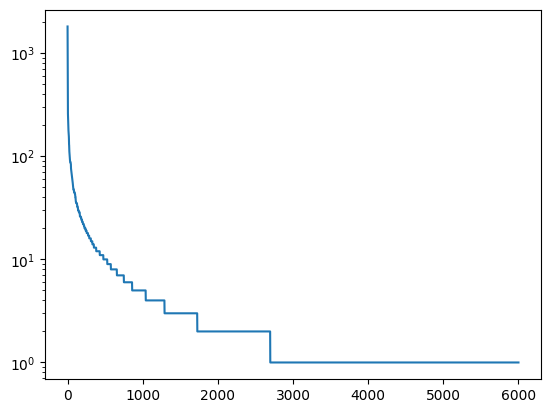

In [21]:
# Plot the distribution of word occurrences in the 'after' dataset.
plt.figure()
plt.semilogy(-np.sort(-np.sum(Mwd_after,axis=1)))
plt.savefig(out_dir+out_file+"_statistics_after.png")

In [22]:
# Filter out words with low occurrence
select_after = (np.sum(Mwd_after,axis=1)>2)
Mwd_after = Mwd_after[select_after,:]
words_after = words_after[select_after]
# Filter out documents that do not contain words
select_after = (np.sum(Mwd_after,axis=0)>0)
Mwd_after = Mwd_after[:,select_after]
documents_after = documents_after[select_after]
# Display the shape of the final word occurrence matrix after filtering
display(Mwd_after.shape)

(1726, 4483)

In [28]:
# Save the result
pickle.dump([Mwd_after,words_after,documents_after], open(out_dir+out_file+"after_occurrences.p", "wb"))
# c,d,e = pickle.load(open(out_dir+out_file+"_occurrences.p","rb"))

In [29]:
!pip install bertopic
from bertopic import BERTopic

In [30]:
%run "/content/drive/MyDrive/NetworkScience_Project/Reddit/communities_mod.ipynb"

bertopic 1.11
softlouvain v1.10


In [31]:
in_dir = "/content/drive/MyDrive/NetworkScience_Project/Reddit/"
in_file = "final_barbie_reddit_after"

# Load the serialized word occurrence data
Mwd, words, documents = pickle.load(open(in_dir+in_file+"_occurrences.p","rb"))
Mwd = sps.csr_matrix(Mwd)

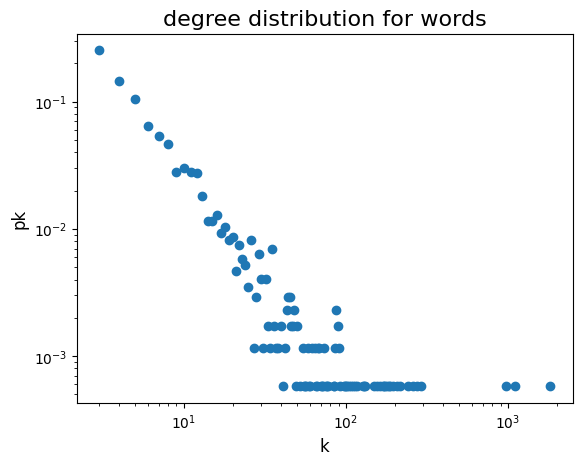

In [32]:
# Calculate the degree distribution for words within the word occurrence matrix
dw = np.squeeze(np.asarray(Mwd.sum(axis=1))) # words degrees
k = np.unique(dw)
pk = np.histogram(dw,np.append(k,k[-1]+1))[0]
pk = pk/pk.sum()
Pk = 1-np.cumsum(pk)
fig = plt.figure()
plt.loglog(k,pk,'o')
plt.title("degree distribution for words", size=16)
plt.xlabel("k", size=12)
plt.ylabel("pk", size=12)
plt.show()

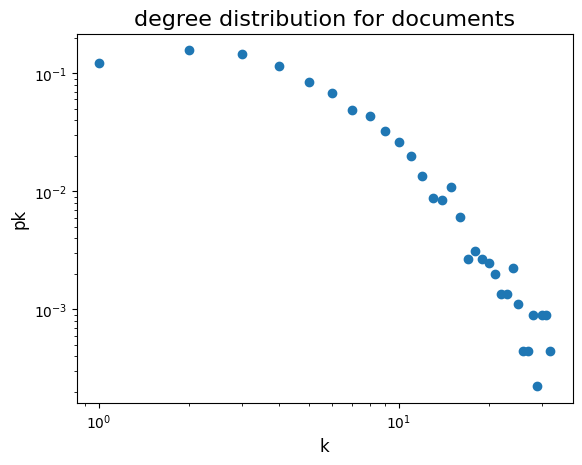

In [33]:
# Calculate the degree distribution for documents within the word occurrence matrix
dd = np.squeeze(np.asarray(Mwd.sum(axis=0))) # documents degrees
k = np.unique(dd)
pk = np.histogram(dd,np.append(k,k[-1]+1))[0]
pk = pk/pk.sum()
Pk = 1-np.cumsum(pk)
fig = plt.figure()
plt.loglog(pk,'o')
plt.title("degree distribution for documents", size=16)
plt.xlabel("k", size=12)
plt.ylabel("pk", size=12)
plt.show()

In [34]:
# Remove elements that are excessively central
Mwd, words, documents = clean_Mwd_matrix(Mwd,words,documents)

removing: barbie PROPN kenergy PROPN 


In [35]:
# Construct probability matrices
Pwd, Pww, Pdd, Paa = probability_matrices(Mwd, tform=False)

In [36]:
# Start a timer to measure the execution time
tic = time.time()

# Generate a graph from the document-document probability matrix
A = sps.csr_matrix(Pdd)
G = ig.Graph.Adjacency((A > 0).toarray().tolist())
G.es['weight'] = np.array(A[A.nonzero()])[0]

# Apply the Louvain algorithm to the graph for community detection
part = louvain.find_partition(G, louvain.ModularityVertexPartition,
                                 weights='weight')

# Define a function to convert the Louvain partitioning result into a community assignment matrix (C)
def partition_to_C(part):
  C = sps.csr_matrix((Pdd.shape[0],len(part)))
  for i in range(len(part)):
    C[np.array(part[i]),i] = 1
  return C

# Convert the Louvain partition into a community assignment matrix
C_l = partition_to_C(part)

# Record the time taken to perform the initial Louvain
et_louv = time.time()-tic

# Apply a refinement step with a 'soft' Louvain algorithm variant
C_sl, _, _ = my_soft_louvain(Pdd, C_l)

# Record the total execution time
et_slouv = time.time()-tic

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[3998, 3998]
369.1097397793796
140.00714267493635
74.95331880577397
48.083261120685215
22.62741699796953
7.0710678118654755
1.4142135623730951
0.0
[3998, 29]
14.142135623730955
0.0
[3998, 26]
0.0


In [39]:
# Load the cleaned text data
df2 = pd.read_excel(in_dir+in_file+"_cleaned.xlsx")
df2["id"] = np.array([str(i) for i in df2["id"]])

# Filter 'df2' to include only those documents that are present in the community assignment matrix 'Pcc'
documents = np.array([str(i) for i in documents])
df2 = df2.loc[df2['id'].isin(documents)]
df2.index = np.array(range(len(df2)))

# Reinsert hashtags into the cleaned text
df2["text_deep_clean2"] = [str(df2["text_deep_clean"][i]) + " #" +
                           df2["hashtags"][i][2:-2].replace("', '"," #")
                           for i in range(len(df2))]

In [40]:
# Start a timer to measure the execution time for topic modeling with BERTopic
tic = time.time()

# Initialize a BERTopic instance for topic modeling
bert_model = BERTopic()

# Perform topic modeling on the documents using BERTopic
docs = list(df2["title"])
topics, probabilities = bert_model.fit_transform(docs)

# Define a function to convert the topic assignments into a community assignment matrix
def topics_to_C(topics):
  # extract community assignments
  C = sps.csr_matrix((len(topics),max(topics)+2))
  for i in range(C.shape[1]):
    C[np.array(topics)==(i-1),i] = 1
  # remove zero assignments
  C = C[:,np.unique(scipy.sparse.find(C)[1])]
  return C

# Convert the list of topic assignments into a community assignment
C_b = topics_to_C(topics)

# Calculate and capture the execution time
et_bert = time.time()-tic

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [41]:
# Initialize a DataFrame
df = pd.DataFrame(data={'data':[],'algo':[],'time':[],'c#':[],
                        'NMI':[],'Q':[],'Ncut':[],'InfoMap':[]})

# Compute the Infomap ranking vector 'r'
r = infomap_rank(Pdd)

In [42]:
# Evaluate clustering performance metrics for the hard Louvain method
stats = clustering_statistics(C_l,Pwd,Pdd,r)
# Store them into the dataframe
df.loc[len(df)] = [in_file,"hard Louvain Pdd",et_louv,C_l.shape[1]] + stats

# Evaluate clustering performance metrics for the soft Louvain method
stats = clustering_statistics(C_sl,Pwd,Pdd,r)
# Store them into the dataframe
df.loc[len(df)] = [in_file,"soft Louvain Pdd",et_slouv,C_sl.shape[1]] + stats

# Evaluate clustering performance metrics for the hard BERTopic method
stats = clustering_statistics(C_b,Pwd,Pdd,r)
# Store them into the dataframe
df.loc[len(df)] = [in_file,"BERTopic",et_bert,C_b.shape[1]] + stats

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [43]:
# Display the result
display(df)

,data,algo,time,c#,NMI,Q,Ncut,InfoMap
0,final_barbie_reddit_after,hard Louvain Pdd,91.801824,29,0.496738,0.354774,0.606016,0.000781
1,final_barbie_reddit_after,soft Louvain Pdd,141.448204,26,0.495452,0.356705,0.596667,0.002046
2,final_barbie_reddit_after,BERTopic,112.643500,61,0.447739,0.180257,0.770064,0.053339


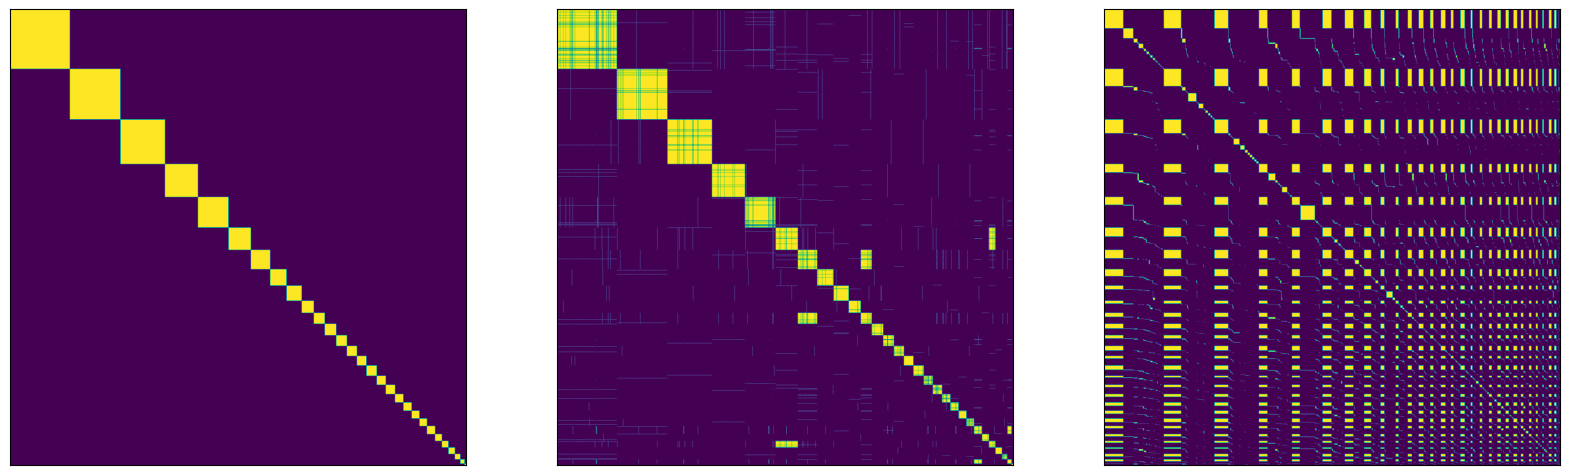

In [44]:
#  Visualize the community structures
plot_community_patterns([C_l,C_sl,C_b],nrows=1,ncols=3,refs=[0,2])

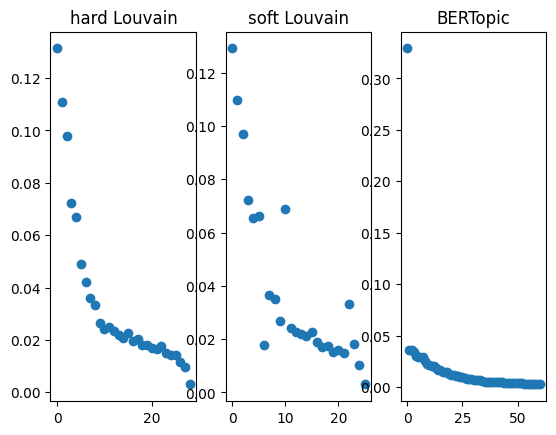

In [45]:
# visualizes the distribution of documents across communities
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(np.array(C_l.sum(axis=0))[0]/C_l.sum(),'o')
ax1.set_title('hard Louvain')
ax2.plot(np.array(C_sl.sum(axis=0))[0]/C_sl.sum(),'o')
ax2.set_title('soft Louvain')
ax3.plot(np.array(C_b.sum(axis=0))[0]/C_b.sum(),'o')
ax3.set_title('BERTopic');

In [46]:
# Initialize a BERTopic model customized for the communities identified by Louvain
docs = list(df2["text_deep_clean2"])
bert_model1 = bertopic_overwrite(bert_model,docs,C_l)

# Visualize the top words for each topic (community) identified
bert_model1.visualize_barchart(topics = range(C_l.shape[1]),
                               n_words = 8,
                               title = "Louvain results")

In [47]:
# BERTopic second

# use the clean text in order to get a more meaningful description
docs = list(df2["text_deep_clean2"])
bert_model2 = bertopic_overwrite(bert_model,docs,C_b)

# visualize topic description
bert_model2.visualize_barchart(topics = range(C_b.shape[1]),
                               n_words = 8,
                               title = "BERTopic results")

In [48]:
topics = bert_model1.get_topics()
print(topics)

{0: [('watch', 0.06124424753717156), ('movie', 0.05917662163437161), ('barbie', 0.042266982347640654), ('people', 0.04221691276170518), ('dress', 0.032330947406243316), ('want', 0.031575002653451485), ('theater', 0.03010416150109315), ('ready', 0.029877590123775756), ('finally', 0.028310667009813766), ('party', 0.027826770764713567)], 1: [('office', 0.062137364698742634), ('box', 0.061811396580534035), ('million', 0.04035376589449103), ('weekend', 0.03976197421909812), ('day', 0.038314363520541225), ('gross', 0.03788529087833217), ('big', 0.03647780628833318), ('warner', 0.03579303737689526), ('oppenheimer', 0.03576063532696118), ('domestic', 0.032054823117814275)], 2: [('oscar', 0.05948364154303154), ('gerwig', 0.05288853890204122), ('greta', 0.052339508817254), ('robbie', 0.04911627505625933), ('margot', 0.049018234562773884), ('ryan', 0.04222423594809953), ('nomination', 0.03662907053479586), ('award', 0.032023648150264254), ('gosle', 0.030623872615508047), ('good', 0.03031881058011

In [49]:
topics = bert_model1.get_topics()
new_df = pd.DataFrame.from_dict(topics, orient='index')

ktopics = []

for topic_list in range(0, new_df.shape[1]):
  for topic in range(0, new_df.shape[0]):
      ktopics.append(new_df[topic_list][topic][0])

unique_ktopics  = set(ktopics)
topics_ktopics = list(unique_ktopics)

In [50]:
# Load the CSV file
df = pd.read_excel("drive/MyDrive/NetworkScience_Project/Reddit/final_barbie_reddit_after_cleaned.xlsx")

# Extract all keywords from the BERT model's output
keywords = topics_ktopics

df["hashtags_2"] = None
for i in range(len(df["text_deep_clean"])):
  if isinstance(df["text_deep_clean"][i], str):  # Check if text is a string
    hashtags2 = []

    for word in df["text_deep_clean"][i].split():

      if word in keywords:
        #  print(type(word))
          hashtags2.append(str(word))
          df["hashtags_2"][i] = hashtags2

In [51]:
df.to_pickle('drive/MyDrive/NetworkScience_Project/Reddit/final_barbie_reddit_after_cleaned.pkl')

In [52]:
comments_df = pd.read_pickle("drive/MyDrive/NetworkScience_Project/Reddit/final_barbie_reddit_after_cleaned.pkl")

In [53]:
comments_filtered = comments_df.copy()
column_list = ["id","created", "text_deep_clean", "text_deep_clean_pos", "hashtags_2"]
comments_filtered = comments_filtered[column_list]

In [54]:
#initialize an empty dict
unique_words = {}
for row in comments_filtered["text_deep_clean"]:
    if pd.notna(row):
        # Split the row into words and iterate over them
        for word in row.split(" "):
            #if the word is encountered for the first time add to dict as key and set its value to 0
            unique_words.setdefault(word,0)
            #increase the value (i.e the count) of the word by 1 every time it is encountered
            unique_words[word] += 1

In [55]:
uw_df = pd.DataFrame.from_dict(unique_words, orient='index').reset_index()
uw_df.rename(columns = {'index':'Word', 0:'Count'}, inplace=True)
uw_df.sort_values(by=['Count'], ascending=False, inplace=True)
uw_df

,Word,Count
7,barbie,3034
8,movie,1114
609,m,274
14,oppenheimer,252
35,ken,211
...,...,...
2758,pls,1
2759,ala,1
2761,eurovision,1
2762,saga,1


In [56]:
unique_hashtags = {}


for idx, row in comments_filtered.iterrows():
  hashtag_list = []
  try:
    for hashtag in row["hashtags_2"]:
      unique_hashtags.setdefault("#"+hashtag, 0)
      unique_hashtags['#'+hashtag] += 1
      hashtag_list.append(hashtag)
  except:
      continue

In [57]:
uh_df = pd.DataFrame.from_dict(unique_hashtags, orient='index').reset_index()
uh_df.rename(columns = {'index':'Hashtag', 0:'Count'}, inplace=True)
uh_df.sort_values(by=['Count'], ascending=False, inplace=True)

Network Building

In [58]:
import itertools
import networkx as nx

In [59]:
uh = unique_hashtags.keys()
uw = unique_words.keys()

In [60]:
import numpy as np
network = {}
for index, row in comments_filtered.iterrows():
    combined_list = row['hashtags_2']  # Use keys() to get the list of unique subreddits
    if isinstance(combined_list, list):
      for pair in itertools.product(combined_list, combined_list):
          if pair[0] != pair[1] and not (pair[::-1] in network):
              #breakpoint()
              network.setdefault(pair, 0)
              # Update the weight based on actual occurrences
              network[pair] += 1

network_df = pd.DataFrame.from_dict(network, orient="index")

In [61]:
network_df.reset_index(inplace=True)
network_df.columns = ["pair","weight"]
network_df.sort_values(by="weight",inplace=True, ascending=False)
network_df

,pair,weight
9,"(barbie, movie)",947
18,"(barbie, oppenheimer)",245
41,"(barbie, ken)",216
12,"(watch, barbie)",155
162,"(box, office)",152
...,...,...
2028,"(domestic, gosle)",1
2027,"(domestic, ryan)",1
2026,"(domestic, robbie)",1
2025,"(domestic, margot)",1


In [62]:
#to get weighted graph we need a list of 3-element tuplels (u,v,w) where u and v are nodes and w is a number representing weight
up_weighted = []
for edge in network:
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted.append((edge[0],edge[1],network[edge]))

G = nx.Graph()
G.add_weighted_edges_from(up_weighted)

In [63]:
print(len(G.nodes()))
print(len(G.edges()))

275
3786


In [64]:
filename = "drive/MyDrive/NetworkScience_Project/Reddit/barbie_edgelist_after_released.csv"

In [65]:
nx.write_weighted_edgelist(G, filename, delimiter=",")

In [66]:
word_nodes = pd.DataFrame.from_dict(unique_words,orient="index")
word_nodes.reset_index(inplace=True)
word_nodes["Label"] = word_nodes["index"]
word_nodes.rename(columns={"index":"Id",0:"delete"},inplace=True)
word_nodes = word_nodes.drop(columns=['delete'])

In [67]:
hashtag_nodes = uh_df.copy()
hashtag_nodes["Label"] = hashtag_nodes["Hashtag"]
hashtag_nodes.rename(columns={"Hashtag":"Id"},inplace=True)
hashtag_nodes = hashtag_nodes.drop(columns=['Count'])

In [68]:
nodelist = hashtag_nodes
nodelist.to_csv("drive/MyDrive/NetworkScience_Project/Reddit/barbie_nodelist_after_released.csv",index=False)

In [69]:
a = pd.read_csv("drive/MyDrive/NetworkScience_Project/Reddit/barbie_edgelist_after_released.csv")

In [70]:
a.columns = ['Source','Target','Label']

In [71]:
a.to_csv("drive/MyDrive/NetworkScience_Project/Reddit/barbie_edgelist_after_released.csv",index=False)